In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
sys.path.append('../../')

from sdebridge.setup import *
from sdebridge.sde import SDE
from sdebridge.diffusion_bridge import DiffusionBridge

from matplotlib import colormaps

2024-01-26 12:28:29.781962: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-26 12:28:29.781997: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-26 12:28:29.783162: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-26 12:28:31.197125: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/gefan/miniconda3/envs/sdebridge/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonoteboo

In [98]:
def sample_ellipse(
    n_samples: int,
    scale: float = 1.0,
    shifts: np.ndarray = np.array([0.0, 0.0]),
    a: float = 1.0,
    b: float = 1.0,
) -> np.ndarray:
    theta = np.linspace(0, 2 * np.pi, n_samples, endpoint=False)
    x = a * np.cos(theta)
    y = b * np.sin(theta)
    return scale * np.stack([x, y], axis=1) + shifts[None, :]

def evaluate_S(S: jnp.ndarray, n: int) -> jnp.ndarray:
    S_coeffs = jnp.fft.rfft(S, norm="forward", axis=0)  # (n_samples, 2)
    S_eval = jnp.fft.irfft(S_coeffs, norm="forward", n=n, axis=0) # (n_bases, 2)
    return S_eval 

def evaluate_X_coeffs(X_coeffs: jnp.ndarray, n: int) -> jnp.ndarray:
    X_eval = jnp.fft.irfft(X_coeffs, norm="forward", n=n, axis=0)  # (n_bases, 2)
    return X_eval

def gaussian_kernel_2d(x: jnp.ndarray, y: jnp.ndarray, sigma: float, alpha: float) -> jnp.ndarray:
    return alpha * jnp.exp(-jnp.linalg.norm(x - y, axis=-1) ** 2 / (2 * sigma ** 2))

def evaluate_Q(X_coeffs: jnp.ndarray, S0_eval: jnp.ndarray, sigma: float, alpha: float) -> jnp.ndarray:
    ks = jnp.fft.fftfreq(S0_eval.shape[0], d=1.0/(2.0*np.pi))  # (n_bases, )
    kks = jnp.stack(jnp.meshgrid(ks, ks, indexing='ij'), axis=-1)
    kernel_func = partial(gaussian_kernel_2d, sigma=sigma, alpha=alpha)
    St_eval = evaluate_X_coeffs(X_coeffs, n=S0_eval.shape[0]) + S0_eval   # (n_bases, 2)
    Q_eval = vmap(
        vmap(
            vmap(kernel_func, 
                 (None, 0), 
                 0), 
            (None, 1), 
            1), 
        (0, None), 
        0)(St_eval, kks)
    return Q_eval

def evaluate_Q_coeffs(X_coeffs: jnp.ndarray, S0_eval: jnp.ndarray, sigma: float, alpha: float) -> jnp.ndarray:
    Q_eval = evaluate_Q(X_coeffs, S0_eval, sigma, alpha) # (n_bases, n_bases, n_bases)
    Q_coeffs = jnp.fft.fftn(Q_eval, norm="forward", axes=(0, 1, 2))    # (n_bases, n_bases, n_bases)
    return Q_coeffs.reshape(Q_coeffs.shape[0], -1)

#### Circles

S0 shape:  (64, 2)
ST shape:  (64, 2)


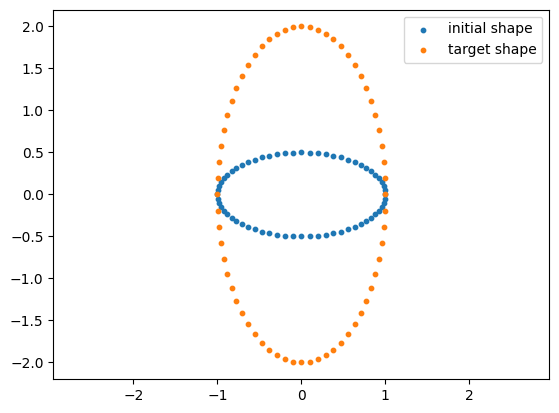

In [99]:
n_samples = 64
n_bases = 8

S0 = sample_ellipse(n_samples, scale=1.0, a=1.0, b=0.5)
ST = sample_ellipse(n_samples, scale=2.0, b=1.0, a=0.5)
print("S0 shape: ", S0.shape)
print("ST shape: ", S0.shape)
plt.scatter(S0[:, 0], S0[:, 1], s=10, label='initial shape')
plt.scatter(ST[:, 0], ST[:, 1], s=10, label='target shape')
plt.legend()
plt.axis('equal')
plt.show()

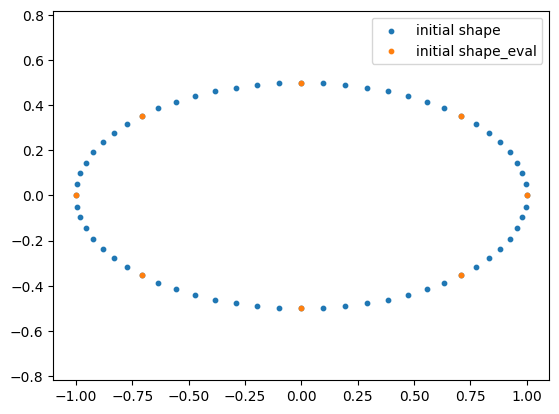

In [100]:
S0_eval = evaluate_S(S0, n=n_bases)

plt.scatter(S0[:, 0], S0[:, 1], s=10, label='initial shape')
plt.scatter(S0_eval[:, 0], S0_eval[:, 1], s=10, label='initial shape_eval')
plt.axis('equal')
plt.legend()

In [106]:
class GaussianKernelFuncBasisSDE(SDE):
    def __init__(self, config: ConfigDict):
        self.config = config

    def drift(self, val: ArrayLike, time: ArrayLike) -> jnp.ndarray:
        return jnp.zeros_like(val)
    
    def diffusion(self, val: ArrayLike, time: ArrayLike) -> jnp.ndarray:
        return evaluate_Q_coeffs(val, self.config.S0_eval, self.config.sigma, self.config.alpha)

XT_coeffs shape: 
 (8, 2)


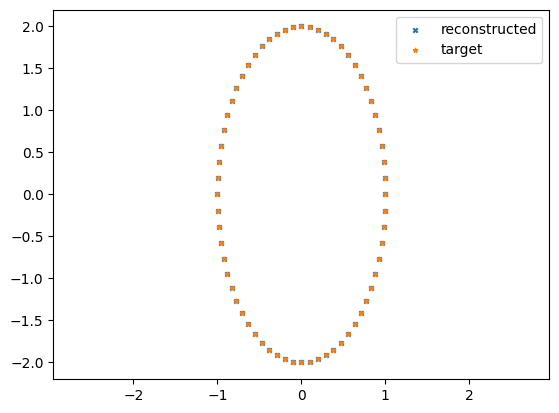

In [107]:
X0 = jnp.zeros((n_bases, 2), dtype=jnp.complex64)

XT = ST - S0
XT_coeffs = jnp.fft.rfft(XT, norm="forward", n=n_samples, axis=0)
XT_coeffs = XT_coeffs[:n_bases, :]
print("XT_coeffs shape: \n", XT_coeffs.shape) 
XT_recon = jnp.fft.irfft(XT_coeffs, norm="forward", n=n_samples, axis=0)

ST_recon = S0 + XT_recon.real
plt.scatter(ST_recon[:, 0], ST_recon[:, 1], s=10, marker='x', label='reconstructed')
plt.scatter(ST[:, 0], ST[:, 1], s=10, marker='*', label='target')
plt.axis('equal')
plt.legend()

In [108]:
sde_config = ConfigDict(
    {
        'S0_eval': S0_eval,
        'T': 1.0,
        'N': 100,
        'dim': 2*n_bases,
        'sigma': 0.5,
        'alpha': 0.5,
    }
)
sde = GaussianKernelFuncBasisSDE(sde_config)
bridge = DiffusionBridge(sde)

In [109]:
forward_uncond = euler_maruyama(sde, initial_vals=jnp.expand_dims(X0, axis=0), terminal_vals=None)

Xs_coeffs shape:  (1, 100, 8, 2)
Xs_recon shape:  (1, 100, 64, 2)
Ss shape:  (1, 100, 64, 2)


(-1.1788274109363557,
 1.169591671228409,
 -0.5907540172338486,
 0.6265392750501633)

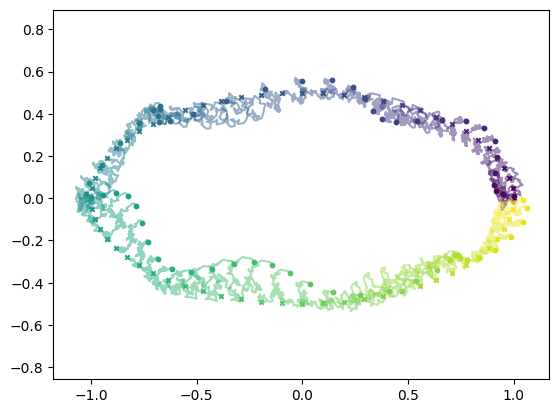

In [110]:
Xs_coeffs = forward_uncond["trajectories"]
print("Xs_coeffs shape: ", Xs_coeffs.shape)
Xs_recon = vmap(vmap(partial(evaluate_X_coeffs, n=n_samples)))(Xs_coeffs)
print("Xs_recon shape: ", Xs_recon.shape)

Ss = S0[None, None, :, :] + Xs_recon.real
print("Ss shape: ", Ss.shape)

# get the colormap
cmap = colormaps.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, n_samples))
for i in range(n_samples):
    plt.scatter(Ss[0, 0, i, 0], Ss[0, 0, i, 1], s=10, marker='x', color=colors[i])
    plt.scatter(Ss[0, -1, i, 0], Ss[0, -1, i, 1], s=10, marker='o', color=colors[i])
    plt.plot(Ss[0, :, i, 0], Ss[0, :, i, 1], color=colors[i], alpha=0.5)
plt.axis('equal')

#### Butterflies

In [111]:
from sdebridge.data_processing import butterfly1_pts, butterfly2_pts, butterfly_honrathi_pts, butterfly_amasina_pts

In [168]:
n_bases = 8

S0 shape:  (130, 2)
ST shape:  (120, 2)


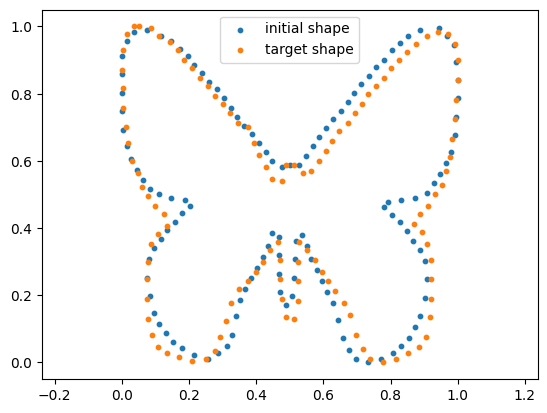

In [169]:
S0 = jnp.array(butterfly_honrathi_pts())[:, ::200][:, 1:].transpose()
ST = jnp.array(butterfly_amasina_pts())[:, ::200].transpose()

print("S0 shape: ", S0.shape)
print("ST shape: ", ST.shape)
plt.scatter(S0[:, 0], S0[:, 1], s=10, label='initial shape')
plt.scatter(ST[:, 0], ST[:, 1], s=10, label='target shape')
plt.legend()
plt.axis('equal')
plt.show()

S0_eval shape:  (8, 2)


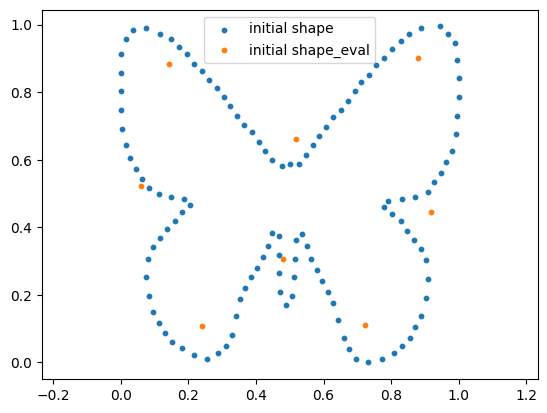

In [170]:
S0_eval = evaluate_S(S0, n=n_bases)
print("S0_eval shape: ", S0_eval.shape)

plt.scatter(S0[:, 0], S0[:, 1], s=10, label='initial shape')
plt.scatter(S0_eval[:, 0], S0_eval[:, 1], s=10, label='initial shape_eval')
plt.axis('equal')
plt.legend()

In [171]:
class GaussianKernelFuncBasisSDE(SDE):
    def __init__(self, config: ConfigDict):
        self.config = config

    def drift(self, val: ArrayLike, time: ArrayLike) -> jnp.ndarray:
        return jnp.zeros_like(val)
    
    def diffusion(self, val: ArrayLike, time: ArrayLike) -> jnp.ndarray:
        return evaluate_Q_coeffs(val, self.config.S0_eval, self.config.sigma, self.config.alpha)

In [172]:
sde_config = ConfigDict(
    {
        'S0_eval': S0_eval,
        'T': 1.0,
        'N': 100,
        'dim': 2*n_bases,
        'sigma': 0.3,
        'alpha': 0.7,
    }
)
sde = GaussianKernelFuncBasisSDE(sde_config)
bridge = DiffusionBridge(sde)

XT shape: 
 (8, 2)
XT (reconstructed) shape: 
 (130, 2)


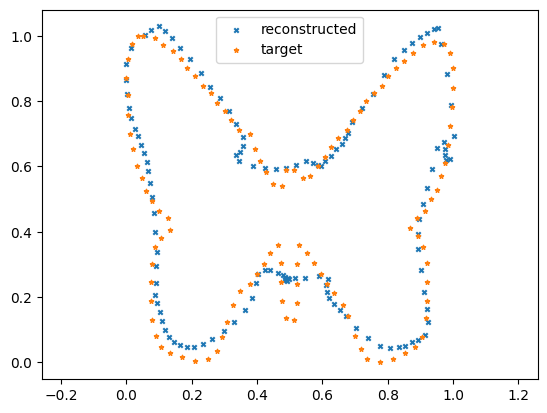

In [173]:
X0 = jnp.zeros((n_bases, 2), dtype=jnp.complex64)

S0_coeffs = jnp.fft.rfft(S0, norm="forward", n=S0.shape[0], axis=0)
ST_coeffs = jnp.fft.rfft(ST, norm="forward", n=ST.shape[0], axis=0)
XT_coeffs = ST_coeffs[:n_bases, :] - S0_coeffs[:n_bases, :]
print("XT shape: \n", XT_coeffs.shape)
XT_recon = evaluate_X_coeffs(XT_coeffs, n=S0.shape[0])
print("XT (reconstructed) shape: \n", XT_recon.shape)

ST_recon = S0 + XT_recon.real
plt.scatter(ST_recon[:, 0], ST_recon[:, 1], s=10, marker='x', label='reconstructed')
plt.scatter(ST[:, 0], ST[:, 1], s=10, marker='*', label='target')
plt.axis('equal')
plt.legend()

In [174]:
forward_uncond = euler_maruyama(sde, initial_vals=jnp.expand_dims(X0, axis=0), terminal_vals=None)

Xs_coeffs shape:  (1, 100, 8, 2)
Xs_recon shape:  (1, 100, 130, 2)
Ss shape:  (1, 100, 130, 2)


(-0.05357981362612918,
 1.1171366717317142,
 -0.12538337633013724,
 1.1031851314008236)

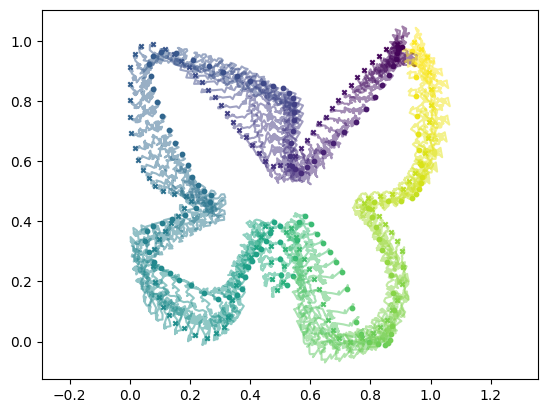

In [175]:
Xs_coeffs = forward_uncond["trajectories"]
print("Xs_coeffs shape: ", Xs_coeffs.shape)
Xs_recon = vmap(vmap(partial(evaluate_X_coeffs, n=S0.shape[0])))(Xs_coeffs)
print("Xs_recon shape: ", Xs_recon.shape)

Ss = S0[None, None, :, :] + Xs_recon
print("Ss shape: ", Ss.shape)

# get the colormap
cmap = colormaps.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, S0.shape[0]))
for i in range(S0.shape[0]):
    # plt.scatter(S0[i, 0], S0[i, 1], s=10, marker='x', color=colors[i])
    plt.scatter(Ss[0, 0, i, 0], Ss[0, 0, i, 1], s=10, marker='x', color=colors[i])
    plt.scatter(Ss[0, -1, i, 0], Ss[0, -1, i, 1], s=10, marker='o', color=colors[i])
    plt.plot(Ss[0, :, i, 0], Ss[0, :, i, 1], color=colors[i], alpha=0.5)
plt.axis('equal')

77488180.0


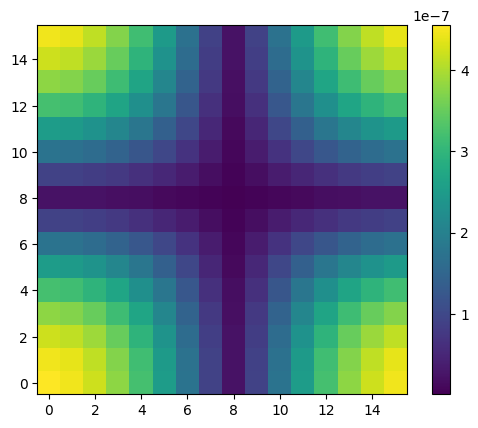

In [155]:
Q_matrix = sde.covariance(XT, time=1.0)
plt.imshow(jnp.abs(Q_matrix), origin='lower', cmap='viridis')
plt.colorbar()
print(jnp.linalg.cond(jnp.abs(Q_matrix)))